In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Ejercicio 1

In [2]:
datos = pd.read_excel('wind_data.xlsx')
print(datos)

       dia  regional wind  wind gap norte sur
0        1       8.000000            0.000000
1        2       8.346296            0.181523
2        3      10.062316            0.188643
3        4      10.791337            0.071085
4        5      10.754093            0.078442
...    ...            ...                 ...
3645  3646       8.642231           -0.869425
3646  3647       6.527408           -1.268447
3647  3648       6.230707           -1.149234
3648  3649       5.550882           -0.420431
3649  3650       6.545450            0.250088

[3650 rows x 3 columns]


In [3]:
datos['wind dif'] = datos['regional wind'].diff().shift(-1) #Si+1 - Si
print(datos)

       dia  regional wind  wind gap norte sur  wind dif
0        1       8.000000            0.000000  0.346296
1        2       8.346296            0.181523  1.716019
2        3      10.062316            0.188643  0.729021
3        4      10.791337            0.071085 -0.037244
4        5      10.754093            0.078442  0.017364
...    ...            ...                 ...       ...
3645  3646       8.642231           -0.869425 -2.114824
3646  3647       6.527408           -1.268447 -0.296701
3647  3648       6.230707           -1.149234 -0.679825
3648  3649       5.550882           -0.420431  0.994568
3649  3650       6.545450            0.250088       NaN

[3650 rows x 4 columns]


In [4]:
#datos_filtrados = datos.dropna(subset=['wind dif'])
datos['theta'] = 6 + 2 * np.cos(2 * np.pi * datos['dia'] / 365)

# Calcular theta(t_i) - S_i
datos['theta_minus_S'] = datos['theta'] - datos['regional wind']
data_filtrada = datos.dropna(subset=['wind dif', 'theta_minus_S'])

slope, intercept, r_value, p_value, std_err = stats.linregress(data_filtrada['theta_minus_S'], data_filtrada['wind dif'])

beta_1 = slope
beta_0 = intercept

print('beta_0:', beta_0)
print('beta_1:', beta_1)
print('std_err:', std_err)

beta_0: -0.01090490726175827
beta_1: 0.29874316789949523
std_err: 0.01177072911949767


In [5]:
kappa = (365 * beta_1)
print('kappa:', kappa)

kappa: 109.04125628331576


In [6]:
# Calcular los residuos
residuos = data_filtrada['wind dif'] - (slope * data_filtrada['theta_minus_S'] + intercept)

# Calcular el error estándar de los residuos
residual_std_err = np.std(residuos, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_std_err)
# Calcular sigma
sigma = residual_std_err * np.sqrt(365)
print('sigma:', sigma)

residual_std_err: 0.8399264390386392
sigma: 16.046772086422457


In [7]:
datos['gap dif'] = datos['wind gap norte sur'] - datos['wind gap norte sur'].shift(1)
print(datos)

       dia  regional wind  wind gap norte sur  wind dif     theta  \
0        1       8.000000            0.000000  0.346296  7.999704   
1        2       8.346296            0.181523  1.716019  7.998815   
2        3      10.062316            0.188643  0.729021  7.997334   
3        4      10.791337            0.071085 -0.037244  7.995261   
4        5      10.754093            0.078442  0.017364  7.992596   
...    ...            ...                 ...       ...       ...   
3645  3646       8.642231           -0.869425 -2.114824  7.995261   
3646  3647       6.527408           -1.268447 -0.296701  7.997334   
3647  3648       6.230707           -1.149234 -0.679825  7.998815   
3648  3649       5.550882           -0.420431  0.994568  7.999704   
3649  3650       6.545450            0.250088       NaN  8.000000   

      theta_minus_S   gap dif  
0         -0.000296       NaN  
1         -0.347482  0.181523  
2         -2.064982  0.007120  
3         -2.796076 -0.117558  
4         -

In [8]:
datos_filtrados_gap = datos.dropna(subset=['gap dif'])

slope_gap, intercept_gap, r_value_gap, p_value_gap, std_err_gap = stats.linregress(datos_filtrados_gap['wind gap norte sur'], datos_filtrados_gap['gap dif'])

beta_1_gap = slope_gap
beta_0_gap = intercept_gap

print('beta_0:', beta_0_gap)
print('beta_1:', beta_1_gap)

beta_0: -0.004013223850057093
beta_1: 0.1325505861738276


In [9]:
beta = 365 * beta_1_gap
beta

48.38096395344707

In [10]:
# Calcular los residuos
residuos_gap = datos_filtrados_gap['gap dif'] - (slope_gap * datos_filtrados_gap['wind gap norte sur'] + intercept_gap)

# Calcular el error estándar de los residuos
residual_gap_std_err = np.std(residuos_gap, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_gap_std_err)
# Calcular sigma
gamma = residual_gap_std_err * np.sqrt(365)
print('gamma:', gamma)

residual_std_err: 0.5282417805574243
gamma: 10.092045047222316


## Ejercicio 2

In [11]:
def theta(t):
    return 6 + 2 * np.cos(2 * np.pi * t / 365)

In [12]:
def simulacion (n_days):
    S = np.zeros(n_days)
    D = np.zeros(n_days)

        # Valores iniciales (suponemos que S_0 y D_0 son conocidos o se dan como 0)
    S[0] = np.mean(datos['regional wind'])
    D[0] = 0

    for i in range(1, n_days):
        S[i] = S[i - 1] + kappa * (theta(i) - S[i - 1]) * 1/365 + sigma * np.sqrt(1/365) * np.random.normal(0, 1)
            
        D[i] = D[i-1] - beta * D[i-1] * 1/365 + gamma * np.sqrt(1/365) * np.random.normal(0, 1)

    return S, D

In [13]:
S, D = simulacion(3650)

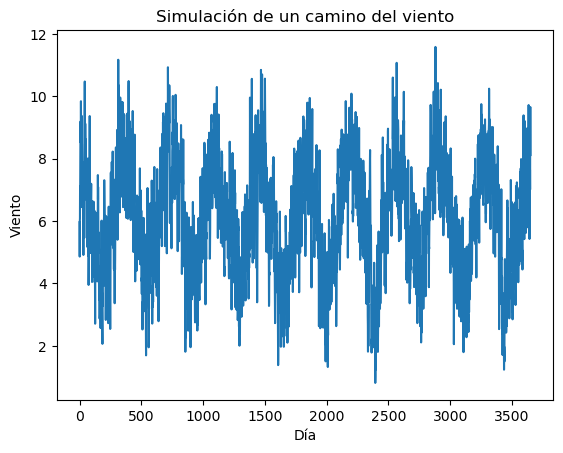

In [14]:
plt.plot(S)
plt.title('Simulación de un camino del viento')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

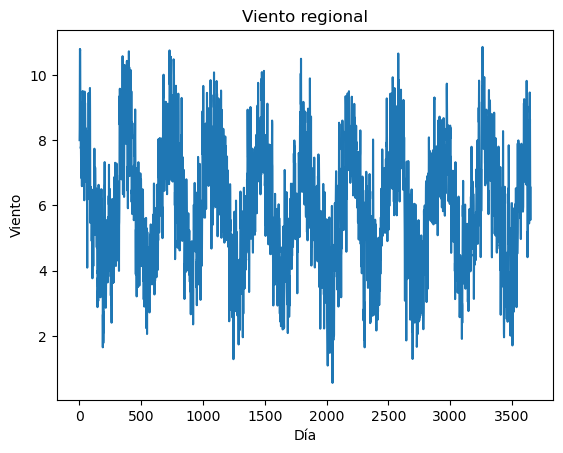

In [15]:
plt.plot(datos['dia'], datos['regional wind'])
plt.title('Viento regional')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

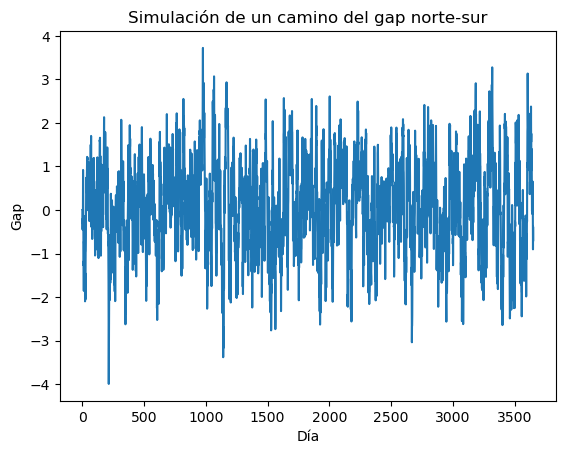

In [16]:
plt.plot(D)
plt.title('Simulación de un camino del gap norte-sur')
plt.xlabel('Día')
plt.ylabel('Gap')
plt.show()

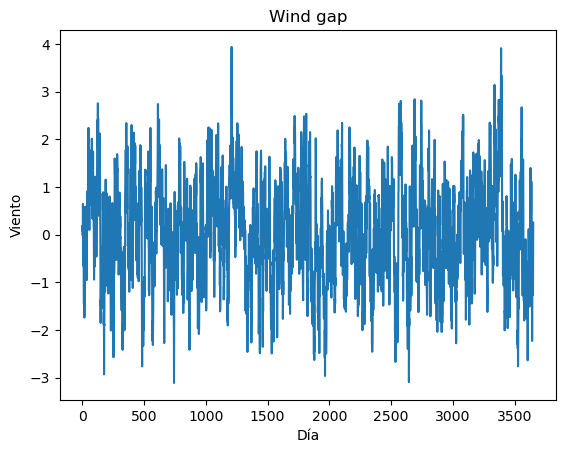

In [17]:
plt.plot(datos['dia'], datos['wind gap norte sur'])
plt.title('Wind gap')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

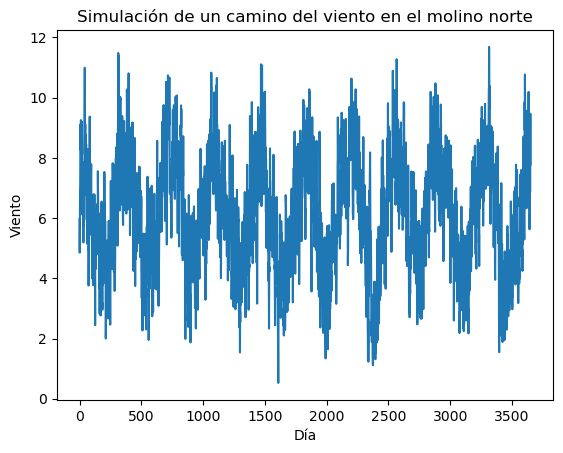

In [18]:
#Viento en molino norte
S_norte = S+D/2

plt.plot(S_norte)
plt.title('Simulación de un camino del viento en el molino norte')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

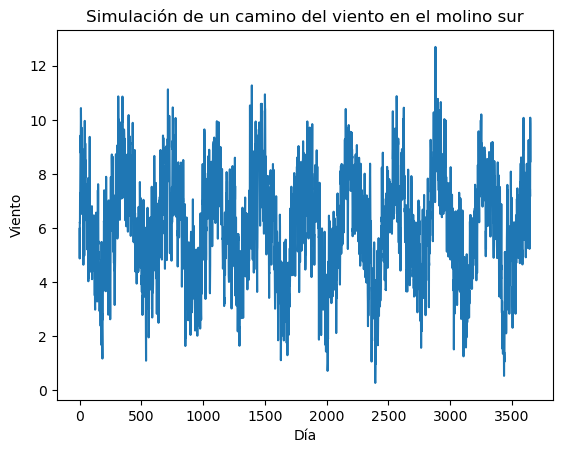

In [19]:
S_sur = S-D/2

plt.plot(S_sur)
plt.title('Simulación de un camino del viento en el molino sur')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

Media del viento simulado: 6.116042264838645
Desviación estándar del viento simulado: 1.8135432229562651
Media del viento histórico: 5.964442822277723
Desviación estándar del viento histórico: 1.8032133987250791
Media de la diferencia simulada: 0.07858207491493176
Desviación estándar de la diferencia simulada: 1.0527249917248036
Media de la diferencia histórica: 0.03078554102481403
Desviación estándar de la diferencia histórica: 1.0614721182882032


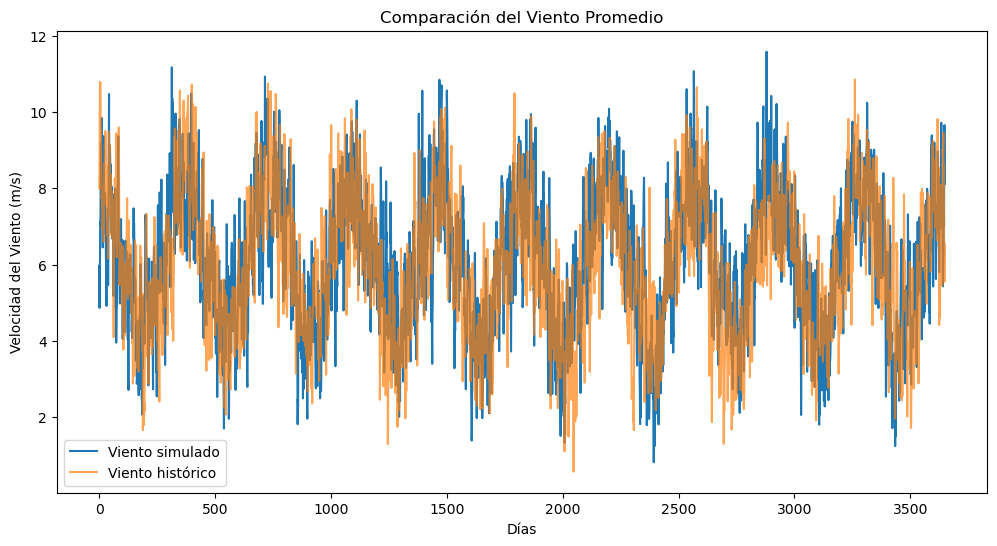

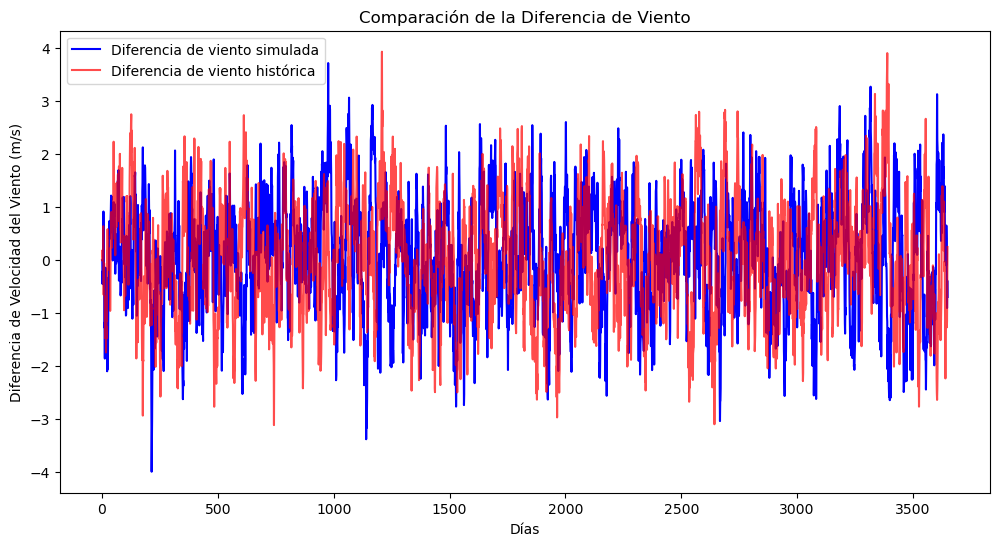

In [20]:
# Supongamos que tienes datos históricos de 'wind' y 'wind dif'
historical_wind = datos['regional wind']
historical_wind_dif = datos['wind gap norte sur']

# Comparación de la media y desviación estándar
print(f"Media del viento simulado: {np.mean(S)}")
print(f"Desviación estándar del viento simulado: {np.std(S)}")
print(f"Media del viento histórico: {np.mean(historical_wind)}")
print(f"Desviación estándar del viento histórico: {np.std(historical_wind)}")

# Similar para la diferencia de viento
print(f"Media de la diferencia simulada: {np.mean(D)}")
print(f"Desviación estándar de la diferencia simulada: {np.std(D)}")
print(f"Media de la diferencia histórica: {np.mean(historical_wind_dif)}")
print(f"Desviación estándar de la diferencia histórica: {np.std(historical_wind_dif)}")

# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(S, label='Viento simulado')
plt.plot(historical_wind, label='Viento histórico', alpha=0.7)
plt.title('Comparación del Viento Promedio')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D, label='Diferencia de viento simulada', color='blue')
plt.plot(historical_wind_dif, label='Diferencia de viento histórica', color='red', alpha=0.7)
plt.title('Comparación de la Diferencia de Viento')
plt.xlabel('Días')
plt.ylabel('Diferencia de Velocidad del Viento (m/s)')
plt.legend()
plt.show()


## Ejercicio 3


In [21]:
def cashflow(S, D, cashflow, k, n_days):
    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    apagados_norte = np.zeros(n_days)
    apagados_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if viento_norte[i] > k:
            estado_molino_norte[i] = 0 #si pasa umbral se apaga
            apagados_norte[i] = 1
            cashflow[i] -= 1000  # Costo de apagar el molino
        elif  viento_norte[i] <= k:
            estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if viento_sur[i] > k:
            estado_molino_sur[i] = 0
            apagados_sur[i] = 1
            cashflow[i] -= 1000  # Costo de apagar el molino
        elif viento_sur[i] <= k:
            estado_molino_sur[i] = 1

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN = np.sum(cashflow * descuentos)

    return VAN, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur, apagados_norte, apagados_sur

In [22]:
cashflows = np.zeros(365)
VAN, estado_molino_norte, estado_molino_sur, roturas_molino_norte, roturas_molino_sur, apagados_molino_norte, apagados_molino_sur = cashflow(S, D, cashflows, 10, 365)
print(f"El Valor Actual Neto (VAN) del proyecto es: {VAN:.2f}")
print(f"Estado del molino norte: {estado_molino_norte}")
print(f"Estado del molino sur: {estado_molino_sur}")
print(f"Número de roturas del molino norte: {np.sum(roturas_molino_norte)}")
print(f"Número de roturas del molino sur: {np.sum(roturas_molino_sur)}")
print(f"Número de apagados del molino norte: {np.sum(apagados_molino_norte)}")
print(f"Número de apagados del molino sur: {np.sum(apagados_molino_sur)}")


El Valor Actual Neto (VAN) del proyecto es: 978812.51
Estado del molino norte: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Ejercicio 4

ValueError: x and y must have same first dimension, but have shapes (365,) and (3650,)

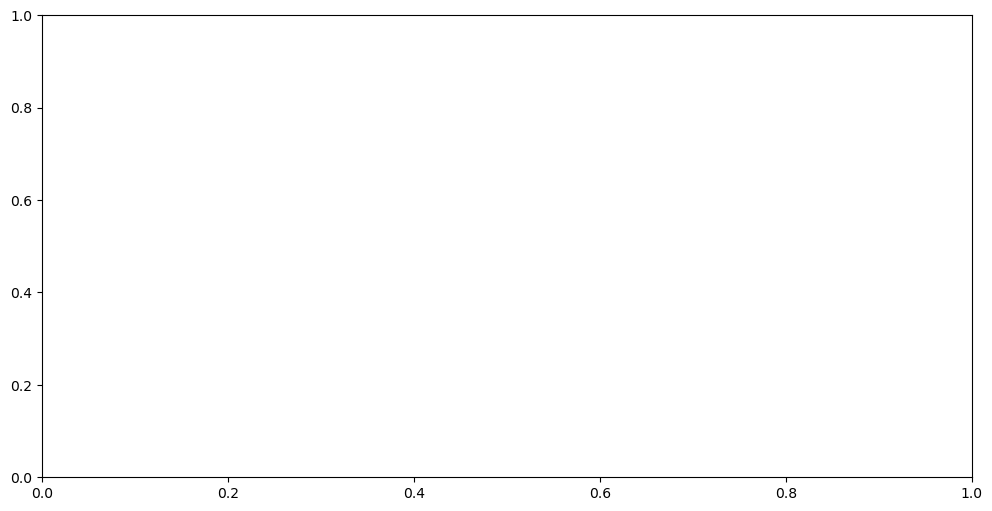

In [23]:
# Días
dias = np.arange(365)

# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, S_norte, label='Viento Molino Norte', color='blue')

# Umbral de apagado
plt.axhline(10, color='red', linestyle='--', label=f'Umbral {10} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_norte == 1], S_norte[roturas_molino_norte == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(S_norte > 10) & (estado_molino_norte == 0)], S_norte[(S_norte > 10) & (estado_molino_norte == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Norte')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


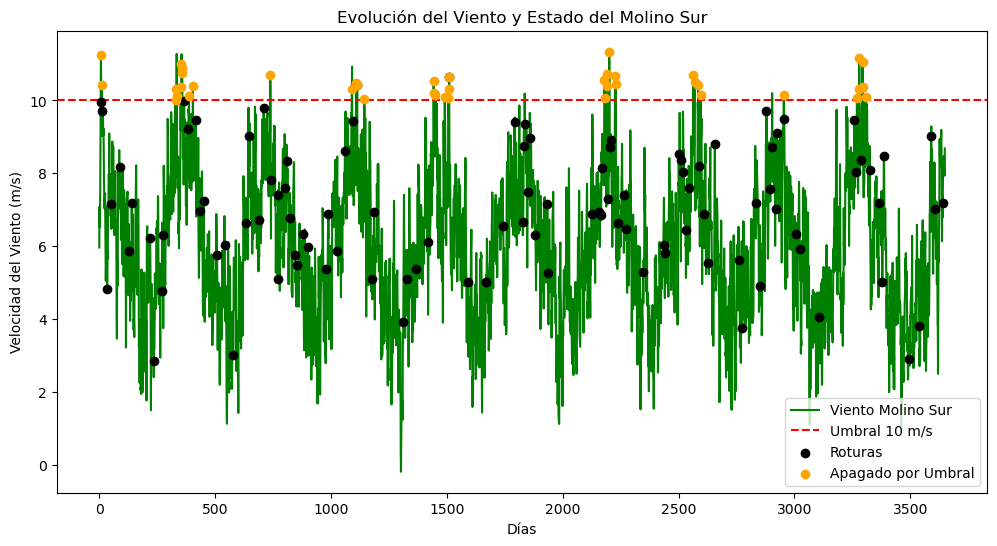

In [31]:
# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, S_sur, label='Viento Molino Sur', color='green')

# Umbral de apagado
plt.axhline(10, color='red', linestyle='--', label=f'Umbral {10} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_sur == 1], S_sur[roturas_molino_sur == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(S_sur > 10) & (estado_molino_sur == 0)], S_sur[(S_sur > 10) & (estado_molino_sur == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Sur')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


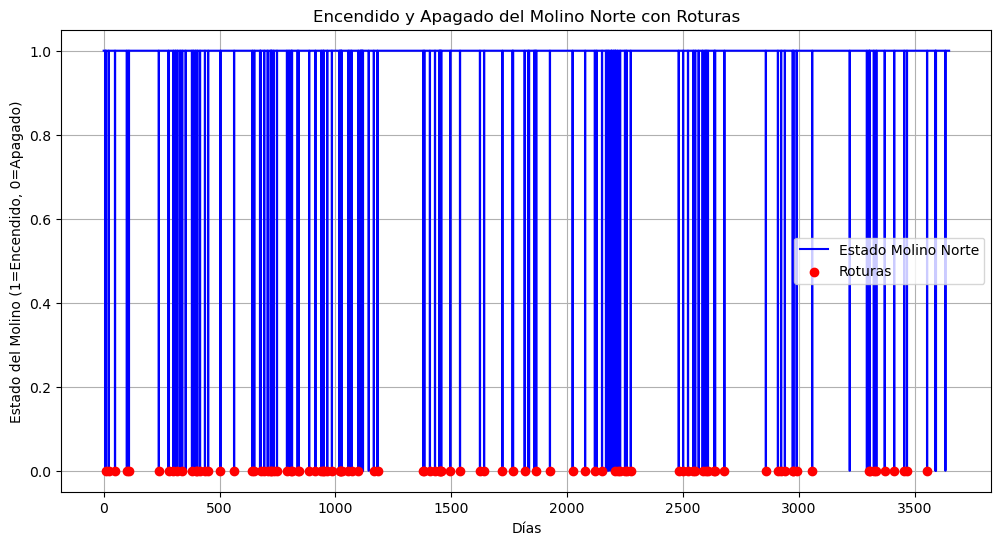

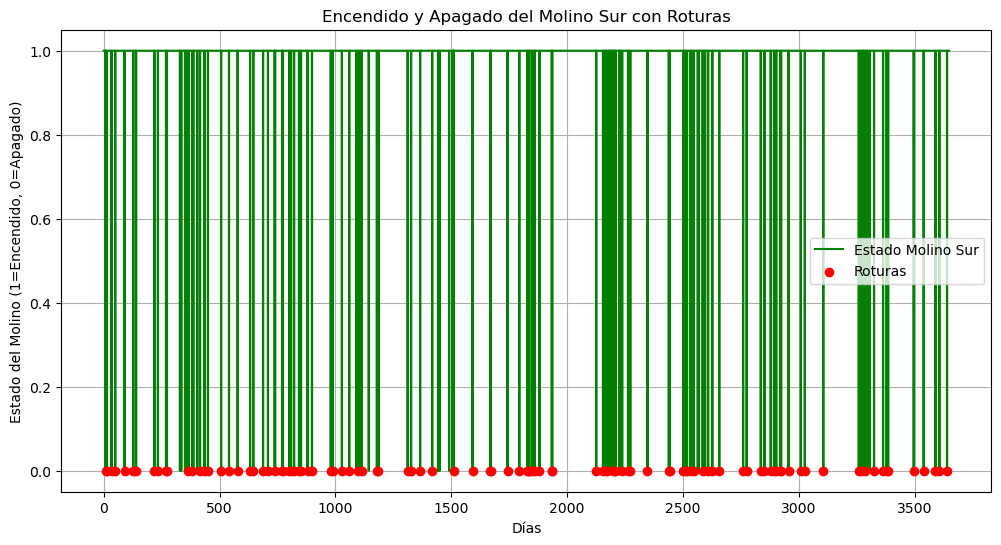

In [32]:
import matplotlib.pyplot as plt

# Días
dias = np.arange(365)

# Gráfico del estado del Molino Norte
plt.figure(figsize=(12, 6))

# Estado del molino Norte (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_norte, label='Estado Molino Norte', color='blue', where='mid')

# Marcar roturas en el molino Norte
plt.scatter(dias[roturas_molino_norte == 1], estado_molino_norte[roturas_molino_norte == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Norte con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico del estado del Molino Sur
plt.figure(figsize=(12, 6))

# Estado del molino Sur (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_sur, label='Estado Molino Sur', color='green', where='mid')

# Marcar roturas en el molino Sur
plt.scatter(dias[roturas_molino_sur == 1], estado_molino_sur[roturas_molino_sur == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Sur con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()


## Ejercicio 5

In [38]:
umbral_k = np.arange(1, 14, 1)
VANs_por_umbral = {}
medias_VAN = {}
errores_VAN = {}
best_van = -np.inf
best_k = None

for k in umbral_k:
    VANs = np.zeros(2000)

    for j in range(2000):
        cashflows = np.zeros(365)
        S, D = simulacion(365)
        VAN, estado_molino_norte, estado_molino_sur, roturas_molino_norte, roturas_molino_sur, apagados_molino_norte, apagados_molino_sur = cashflow(S, D, cashflows, k, 365)
        VANs[j] = VAN
    
    medias_VAN[k] = np.mean(VANs)
    errores_VAN[k] = np.std(VANs) / np.sqrt(2000)

    if medias_VAN[k] > best_van:
        best_van = medias_VAN[k]
        best_k = k

    VANs_por_umbral[k] = VANs


TypeError: 'numpy.ndarray' object is not callable

In [31]:
print('media_por_umbral:', medias_VAN)
print('errores_por_umbral:', errores_VAN)
print('best_k:', best_k)
print('best_van:', best_van)

media_por_umbral: {1: -720759.5755688784, 2: -705981.2837840061, 3: -640831.4733971574, 4: -460910.2282104632, 5: -190299.18505690177, 6: 112344.36615375412, 7: 309275.3948846221, 8: 466812.19272832986, 9: 466181.5730758741, 10: 415071.0607082826, 11: 407648.78067512164, 12: 405238.7165053591, 13: 412012.8369453043}
errores_por_umbral: {1: 1107.462371197104, 2: 1383.3092234882624, 3: 2705.6244641344006, 4: 4780.123472198367, 5: 7660.582977731832, 6: 10359.005977007955, 7: 13787.937669028746, 8: 15842.132964282262, 9: 17766.368177770342, 10: 18865.223562245963, 11: 19168.296498899446, 12: 18970.885322149752, 13: 19002.47711092489}
best_k: 8
best_van: 466812.19272832986


In [32]:
print(len(umbral_k))
print(len(medias_VAN))

13
13


ValueError: 'x' and 'y' must have the same size

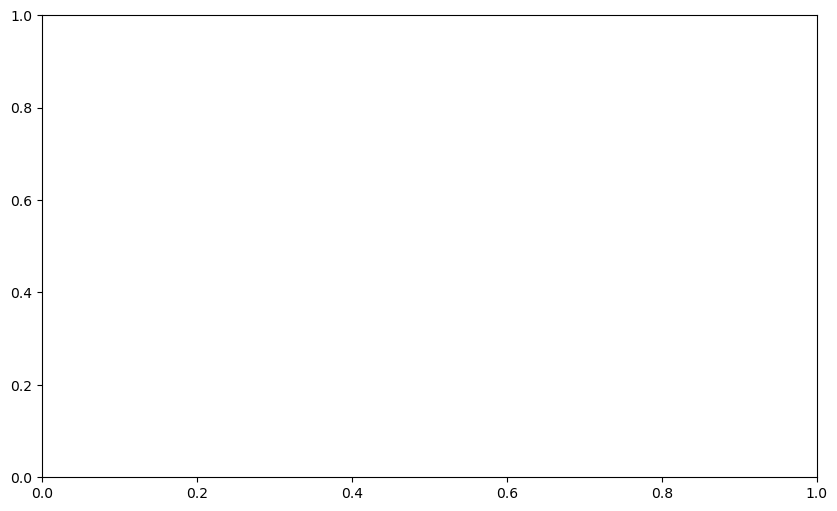

In [33]:
plt.figure(figsize=(10, 6))
plt.errorbar(umbral_k, medias_VAN, yerr=errores_VAN, fmt='-o', label='VAN medio')
plt.title('VAN medio en función del Umbral de Apagado $K$')
plt.xlabel('Umbral de Apagado $K$ (m/s)')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

## Ejercicio 6

In [34]:
print('El valor optimo del umbral es: ', best_k)

El valor optimo del umbral es:  8


## Ejercicio 7

In [35]:
print('Ganancia con el umbral optimo: ', best_van)

#### Para calcular la ganancia ingenua tendriamos que calcular el VAN sin apagar los molinos pero si lo hacemos en otra simulacion perdemos los caminos que usamos en el de VAN, o podemos calcular los caminos en otro lado o meter otro cashflow que no apague los molinos

Ganancia con el umbral optimo:  466812.19272832986


## Ejercicio 8

In [ ]:
# dias del mes de agosto = 213 al 243
cashflow_agosto = [cas]